<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/11_10_ImageAug_CM_CR_ROCcurve_IDC_Prediction_heesuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
W207 Applied Machine Learning<br>
Heesuk Jang
 

#Predicting IDC with Breast Histopathology Images using CNN



In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad, RMSprop
from keras.layers import ReLU, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve

tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Install Optuna and Version Check

In [2]:
# !pip install --quiet optuna
import optuna
optuna.__version__

'3.0.3'

## Enabling and testing the GPU

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Enabling and testing the TPU

In [4]:
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

## Observe TensorFlow speedup on GPU relative to CPU

In [5]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.45968197899992447
GPU (s):
0.048032347999878766
GPU speedup over CPU: 9x


In [6]:
# !unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

#replace these paths with the paths of your 
val_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Validate'
train_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train'
test_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Test'
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC'

In [7]:
def get_paths(directory):
  all_path = []
  idc_image_path = []
  idc_image_label = []

  for dir, subdir, files in os.walk(directory):
    path = dir + "/"
    all_path.append(path)

  for i in range(len(all_path)):
    for file in os.listdir(all_path[i]):
      test = file
      path = all_path[i] + test
      if path.lower().endswith('.png'):
        idc_image_path.append(path)

  for i in range(len(idc_image_path)):
    split_test = idc_image_path[i]
    split_path = split_test.split("/")
    directory_name = split_path[7]
    idc_image_label.append('class_' + split_path[8])
    # idc_image_label.append(str(split_path[8]))
  return idc_image_path, idc_image_label, directory_name

In [8]:
train_paths, train_labels, train_dir = get_paths(train_image_directory)
val_paths, val_labels, val_dir = get_paths(val_image_directory)
test_paths, test_labels, test_dir = get_paths(test_image_directory)

In [9]:
print(train_labels[:5])
print(train_labels[-5:])

print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))
print(len(val_paths), len(val_labels))

['class_0', 'class_0', 'class_0', 'class_0', 'class_0']
['class_1', 'class_1', 'class_1', 'class_1', 'class_1']
800 800
200 200
200 200


In [10]:
print(train_paths[:2])
print(train_labels[:10])
print(train_dir)

['/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12880_idx5_x451_y701_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9345_idx5_x2001_y2001_class0.png']
['class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0', 'class_0']
Train


In [11]:
def create_dataframes(idc_image_path, idc_image_label, directory_name):
  same_name = directory_name.lower() + '_'
  #creating the dataframes that we will be passing to our generators
  idc_data_cleaned = {'path': idc_image_path,
            'label': idc_image_label}
  idc_df = pd.DataFrame(idc_data_cleaned)
  df = idc_df.sample(frac = 1)
  print(df)
  csv_path = directory_path
  csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
  csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
  return csv_file_path

In [12]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
print('type(train_dataframe): ',type(train_dataframe))
train_dataframe

                                                  path    label
441  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
87   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
463  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
269  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
716  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
..                                                 ...      ...
739  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
250  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
644  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
735  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
642  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1

[800 rows x 2 columns]
type(train_dataframe):  <class 'str'>


'/content/gdrive/MyDrive/Kaggle/CNN_IDC/train_idc_dataframe.csv'

In [13]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
train_generator = pd.read_csv(train_dataframe)

test_dataframe = create_dataframes(test_paths, test_labels, test_dir)
test_generator = pd.read_csv(test_dataframe)

val_dataframe = create_dataframes(val_paths, val_labels, val_dir)
val_generator = pd.read_csv(val_dataframe)

                                                  path    label
478  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
230  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
412  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
305  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
300  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
..                                                 ...      ...
221  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
417  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
388  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
26   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
789  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1

[800 rows x 2 columns]
                                                  path    label
150  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
143  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
186  /content/gd

In [14]:
# train_generator

In [15]:
from tqdm import tqdm # import tqdm

# Apply gray scale to all images, flatten and store array / shape in new columns
def get_img_arrays(df,):
    # read each image array from corresponding path as grayscale and flatten the image array
    df['img_array'] = df.progress_apply(lambda x : io.imread(x['path'],as_gray=True).flatten(),axis=1) # make sure to specify axis = 1
    # get the shape of each image array and store it in the dataframe
    df['array_shape'] = df.progress_apply(lambda x : x['img_array'].shape[0],axis=1) # make sure to specify axis = 1
    return df


In [16]:
from tqdm import tqdm # import tqdm
tqdm.pandas() # initialize tqdm for pandas

# # tqdm is a library that enables you to visualize the progress of a for loop by displaying a configurable progress bar

train_generator = get_img_arrays(df = train_generator)
val_generator = get_img_arrays(df = val_generator)
test_generator = get_img_arrays(df = test_generator)

100%|██████████| 200/200 [00:00<00:00, 61603.94it/s]


In [17]:
# print(train_generator.array_shape.value_counts())
# print(val_generator.array_shape.value_counts())
# print(test_generator.array_shape.value_counts())

In [18]:
# drop these images as they add unnecessary noise to our model
train_weird_imgs = train_generator[train_generator['array_shape'] != 2500]
val_weird_imgs = val_generator[val_generator['array_shape'] != 2500]
test_weird_imgs = test_generator[test_generator['array_shape'] != 2500]


weird_imgs = train_weird_imgs.append(val_weird_imgs)
weird_imgs = weird_imgs.append(test_weird_imgs)
weird_imgs['dataset'] = weird_imgs['path'].str.split('/', expand=True)[7]
weird_imgs.reset_index(drop=True)

train_generator.drop(train_weird_imgs.index,inplace=True)
val_generator.drop(val_weird_imgs.index,inplace=True)
test_generator.drop(test_weird_imgs.index,inplace=True)

# print(len(weird_imgs))
# print(len(train_generator))
# print(len(val_generator))
# print(len(test_generator))
# print(train_generator.columns)
# val_generator.reset_index(drop=True)

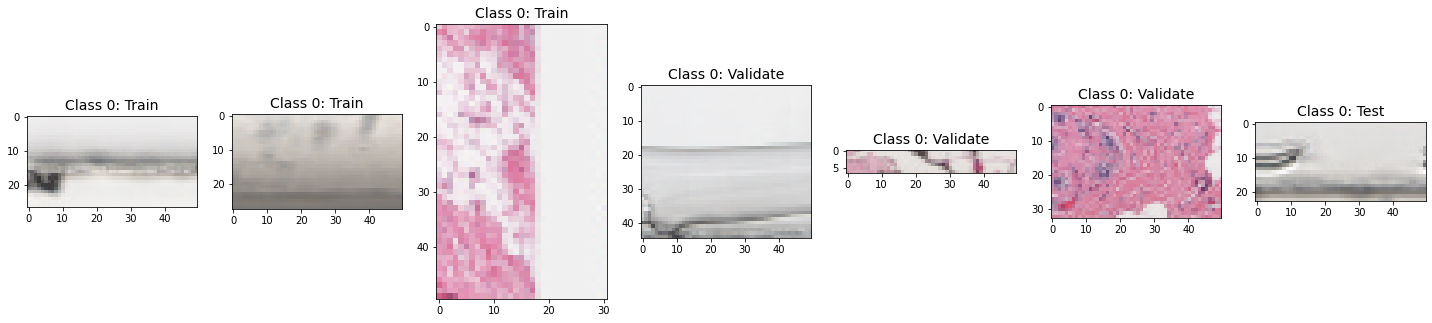

In [19]:
import cv2 as cv
import skimage.io as io

def display_images(subclass):
  fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20,8))
  for idx, ax in enumerate(axes.flat):
    image_wo_path = os.path.basename(subclass.path[idx])
    # print(image_wo_path)
    subtitle = 'Class ' + image_wo_path.rsplit('.')[0][-1] + ': ' + subclass.dataset[idx]
    img = io.imread(subclass.path[idx])
    ax.imshow(img)
    # ax.axis('off')
    ax.set_title(subtitle, size=14)   
  fig.tight_layout() 
  plt.show() 

print()
display_images(weird_imgs.reset_index(drop=True))

In [20]:
# https://faroit.com/keras-docs/0.3.3/preprocessing/image/
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
data_generator = ImageDataGenerator(
    featurewise_center = True,                     # transforms the images to 0 mean
    featurewise_std_normalization = True,          # divide inputs by std of the dataset
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,                  
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None
)

data_generator = ImageDataGenerator()

train_data_generator = ImageDataGenerator(
    featurewise_center = True,               # transforms the images to 0 mean
    featurewise_std_normalization = True,    # divide inputs by std of the dataset
    # rescale=1./255,
    zca_epsilon=1e-06,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    rotation_range=10,                # randomly rotate image by 10 degrees
    shear_range=0.2,                  # distort image along an axis mostly to create or recify the perception angles
    zoom_range=0.2,                   # zomming image: zoom_range > 1 => zoom out, zoom_range < 1 => zoom in
    fill_mode='nearest',              # when the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in, 'nearest': simply replace the empty area with the nearest spectral values.
    horizontal_flip=True
)

# =============== With Image Augmentation ========================
# train_data_generator = train_data_generator.flow_from_dataframe(
#     train_generator,
#     directory = None,
#     x_col =  'path',
#     y_col =  'label',
#     weight_col=None,
#     target_size=(50, 50),
#     color_mode="grayscale",
#     class_mode="categorical",
#     batch_size=32,
#     shuffle=True
#     seed=1234
#     # validate_filenames=True
# )

# =============== Without Image Augmentation =====================
train_data_generator = data_generator.flow_from_dataframe(
    train_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=1234
    # validate_filenames=True
)

validation_data_generator = data_generator.flow_from_dataframe(
    val_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=1234
    # validate_filenames=True
)

test_data_generator = data_generator.flow_from_dataframe(
    test_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=False,              # Kesha set to shuffle=True but we don't want to shuffle our testing data around, which it does so by default
    seed=1234
    # validate_filenames=True
)

Found 797 validated image filenames belonging to 2 classes.
Found 197 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.


# Build CNN Model

In [21]:
img_height = 50
img_width = 50
img_channel = 1
input_shape = (img_height, img_width, img_channel)

In [22]:
from keras.layers import ReLU, LeakyReLU

# 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
#  Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish 
def build_cnn(kernel_size = (3,3),
              strides = (1,1),
              pool_size = (2,2),
              learning_rate = 0.001,
              optimizer = 'Adam',
              activation = 'relu',
              average_over_position=True,
              batch_normalization=True,
              dropout_layer=True,
              dropout_rate=0.5, 
              filters_1=32,
              filters_2=64,
              filters_3=128,
              dense_units=256,
              conv_layer_2=True,
              conv_layer_3=True):    

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(Conv2D(filters=filters_1, kernel_size=kernel_size, padding='same', activation=activation.lower(), input_shape = input_shape))

  def have_batch_normalization(batch_normalization):
    if batch_normalization:
      model.add(BatchNormalization())

  def nn_layer(average_over_position):
    if average_over_position:
      model.add(AveragePooling2D())
    else:
      model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
  
  def have_dropout(dropout_layer):
    if dropout_layer:
      model.add(Dropout(dropout_rate))

  def selected_optimizer(optimizer):
    if optimizer.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)           # SGD(learning_rate=learning_rate, momentum=0.95, decay=1, nesterov=True)
    elif optimizer.lower() == 'adam':
        return Adam(learning_rate=learning_rate)          # Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8, kappa=1-1e-8)
    elif optimizer.lower() == 'adadelta':
        return Adadelta(learning_rate=learning_rate)      # Adadelta(learning_rate=learning_rate, rho=0.95, epsilon=1e-6)
    elif optimizer.lower() == 'adagrad':
        return Adagrad(learning_rate=learning_rate)       # Adagrad(learning_rate=learning_rate, epsilon=1e-6)
    elif optimizer.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)       # RMSprop(learning_rate=learning_rate, rho=0.9, epsilon=1e-6)

  if conv_layer_2:  
    model.add(Conv2D(filters=filters_2, kernel_size=kernel_size, padding='same', activation=activation.lower()))
    have_batch_normalization(batch_normalization)
    nn_layer(average_over_position)
    have_dropout(dropout_layer)

  if conv_layer_3:
    model.add(Conv2D(filters=filters_3, kernel_size=kernel_size, padding='same', activation=activation.lower()))
    have_batch_normalization(batch_normalization)
    nn_layer(average_over_position)
    have_dropout(dropout_layer)

  model.add(Flatten())
  model.add(Dense(units = dense_units, activation = activation))
  have_dropout(dropout_layer)
  model.add(Dense(units = 2, activation = 'softmax'))          # output layer

  model.compile(loss=CategoricalCrossentropy(from_logits=True), 
                optimizer=selected_optimizer(optimizer), 
                metrics=['accuracy'])

  return model

In [23]:
model = build_cnn(kernel_size = (3,3),
              strides = (1,1),
              pool_size = (2,2),
              learning_rate = 0.001,
              optimizer = 'Adam',                # 'Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD'
              activation = 'relu',               # Tanh, Leaky ReLU, Parametric ReLU, ELU, GELU, SELU, Swish
              average_over_position=True,
              batch_normalization=True,
              dropout_layer=True,
              dropout_rate=0.5, 
              filters_1=32,
              filters_2=64,
              filters_3=128,
              dense_units=256,
              conv_layer_2=True,
              conv_layer_3=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 64)       256       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 25, 25, 64)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       7

# Hyperparameter Tuning While Training the Model
- **ReduceLROnPlateau**: A scheduling technique that monitors a particular quantity and decays the learning rate when the quantity is stop improving.
- **ModelCheckpoint**: A sch
- **BatchNormalization**: A feature that we add between the layers of neural network and it continuously takes the output from the previous layer and normalizes it before sending it to the next layer thereby helping stablizing the NN

In [24]:
def model_fit(model, train_data_generator, validation_data_generator, epochs=7):  
  lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

  file_path = 'weights.hdf5'    # save the weights and biases
  checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  history = model.fit(train_data_generator,
                  epochs=epochs,
                  callbacks=[lr_reduce, checkpoint],
                  validation_data = validation_data_generator)
  return history

Epoch 1/7
24/25 [===========================>..] - ETA: 0s - loss: 1.2693 - accuracy: 0.6510
Epoch 1: val_accuracy improved from -inf to 0.49239, saving model to weights.hdf5
25/25 [==============================] - 3s 67ms/step - loss: 1.2447 - accuracy: 0.6512 - val_loss: 15.5704 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 2/7
24/25 [===========================>..] - ETA: 0s - loss: 0.6858 - accuracy: 0.7020
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2: val_accuracy did not improve from 0.49239
25/25 [==============================] - 1s 49ms/step - loss: 0.6782 - accuracy: 0.7039 - val_loss: 4.5290 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 3/7
24/25 [===========================>..] - ETA: 0s - loss: 0.5592 - accuracy: 0.7412
Epoch 3: val_accuracy improved from 0.49239 to 0.51777, saving model to weights.hdf5
25/25 [==============================] - 1s 57ms/step - loss: 0.5517 - accuracy: 0.7465 - val_loss: 1.0949 - val_accuracy: 0.5178 - lr: 1.

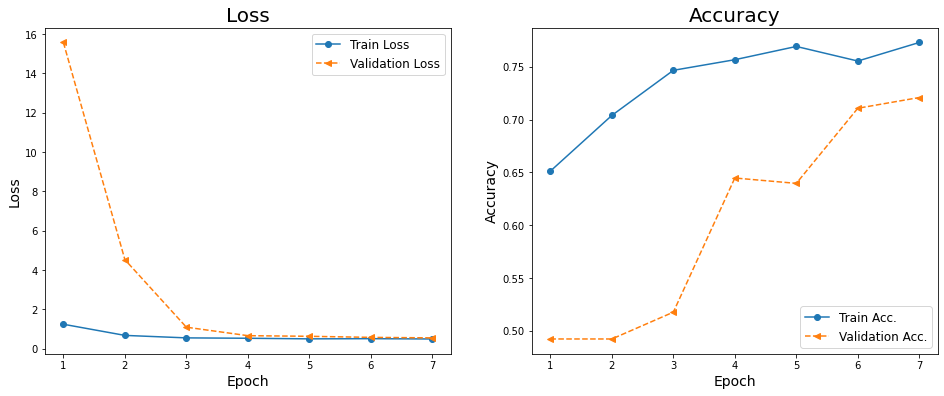

In [25]:
def model_fit_and_plot_loss_acc():
  history = model_fit(model, train_data_generator, validation_data_generator, epochs=7)
  hist = history.history
  x_arr = np.arange(len(hist['loss'])) + 1

  fig = plt.figure(figsize=(16,6))
  ax = fig.add_subplot(1,2,1)
  ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
  ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
  ax.legend(fontsize=12)
  ax.set_xlabel('Epoch', size=14)
  ax.set_ylabel('Loss', size=14)
  ax.set_title('Loss', size=20)

  ax = fig.add_subplot(1,2,2)
  ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
  ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
  ax.legend(fontsize=12)
  ax.set_xlabel('Epoch', size=14)
  ax.set_ylabel('Accuracy', size=14)
  ax.set_title('Accuracy', size=20);

model_fit_and_plot_loss_acc()

In [26]:
def model_evaluate(model, train_data_generator, test_data_generator):
  eval_train = model.evaluate(train_data_generator)
  print(f'Train Accuracy: {eval_train[1]*100:.2f}%')
  print()
  eval_test = model.evaluate(test_data_generator)
  print(f'Test Accuracy: {eval_test[1]*100:.2f}%\n')

model_evaluate(model, train_data_generator, test_data_generator)

25/25 [==============================] - 1s 39ms/step - loss: 0.4987 - accuracy: 0.7867
Train Accuracy: 78.67%

7/7 [==============================] - 0s 38ms/step - loss: 0.5409 - accuracy: 0.7437
Test Accuracy: 74.37%



=============== Classification Report ===============

               precision    recall  f1-score   support

     Non-IDC       0.73      0.77      0.75        99
         IDC       0.76      0.72      0.74       100

    accuracy                           0.74       199
   macro avg       0.74      0.74      0.74       199
weighted avg       0.74      0.74      0.74       199
 



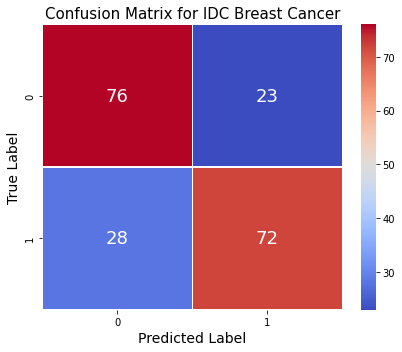

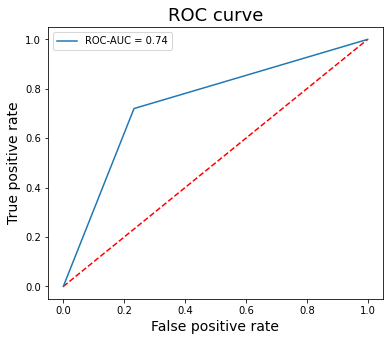


ROC-AUC Score = 0.74


In [27]:
def error_analysis(test_labels, test_data_generator):
  num_of_test_samples = len(test_labels)
  batch_size = 32

  y_true = test_data_generator.classes
  y_pred = model.predict_generator(test_data_generator, num_of_test_samples // batch_size + 1)
  y_pred = np.argmax(y_pred, axis=1)     # return the indicies of the max values along the axis (axis=1: each row)

  # Confusion matrix
  plt.figure(figsize=(6,5))
  conf_max = confusion_matrix(y_true, y_pred)
  sns.heatmap(conf_max, annot=True, cmap='coolwarm', annot_kws={'fontsize':18}, linewidth=0.5, fmt='d')
  
  plt.xlabel('Predicted Label', fontsize=14)
  plt.ylabel('True Label', fontsize=14)
  plt.title('Confusion Matrix for IDC Breast Cancer', fontsize=15)
  plt.tight_layout()
  
  # Classification report
  print('=============== Classification Report ===============\n\n', classification_report(y_true, y_pred, target_names=['Non-IDC', 'IDC']), '\n=====================================================\n')

  # Precision, recall, f1_score
  # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()     # np.ravel(): returns contiguous flattened array (1D array with all the input-array elements and with the same type as it)
  # print(f'============ Precision, Recall, F1_Score ============\n\nTrue Negatives (TN): {tn}\nTrue Positives (TP): {tp}\nFalse Negatives (FN): {fn}\nFalse Positives (FP): {fp}')
  # precision = tp/(tp+fp)
  # recall = tp/(tp+fn)
  # f1_score = (2*precision*recall)/(precision+recall)
  # print(f'\nRecall of the model = {round(recall, 2)}\nPrecision of the model = {round(precision, 2)}\nF1_Score of the model = {round(f1_score, 2)}\n\n====================================================\n')

  # Area under the ROC cuver
  roc_log = roc_auc_score(y_true, y_pred)
  false_positive_rate, true_positive_rate, threshold = roc_curve(y_true, y_pred)
  area_under_curve = auc(false_positive_rate, true_positive_rate)
  
  plt.figure(figsize=(6,5))
  plt.plot([0, 1], [0, 1], 'r--')  
  plt.plot(false_positive_rate, true_positive_rate, label='ROC-AUC = {:.2f}'.format(area_under_curve))  
  plt.xlabel('False positive rate', fontsize=14)
  plt.ylabel('True positive rate', fontsize=14)
  plt.title('ROC curve', fontsize=18)
  plt.legend(loc='best')
  plt.show()
  print(f'\n=====================================================\nROC-AUC Score = {round(area_under_curve, 2)}')
  #plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
  plt.close()
  
error_analysis(test_labels, test_data_generator)

# Transfer Learning
- **ResNet152V2**
- **VGG16**
- **VGG19**

In [28]:
from tensorflow.keras.applications import ResNet152V2, VGG16, VGG19

# https://keras.io/api/applications/
tf.keras.backend.clear_session()
tf.random.set_seed(1234)

input_shape = (50,50,3)
vgg16_base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
vgg19_base_model = VGG19(input_shape=input_shape, include_top=False, weights='imagenet')
resnet_base_model = ResNet152V2(input_shape=input_shape, include_top=False, weights='imagenet')

# vgg16_base_model.summary()
# vgg19_base_model.summary()
# resnet_base_model.summary()

In [29]:
def get_doc_id_model_tl(model_tl):
  return tf.keras.Sequential([
                           model_tl,                           
                           Flatten(),

                           Dense(units = 1024, activation = 'relu'),
                           BatchNormalization(),                           
                           Dropout(rate=0.5),

                           Dense(units = 128, activation = 'relu'),
                           BatchNormalization(),                           
                           Dropout(rate=0.4),

                           Dense(units = 2, activation = 'softmax')
])  

In [30]:
# freeze initial layer of the network, making only the fully connected layer we added trainable
vgg16_base_model.trainable = False
vgg19_base_model.trainable = False
resnet_base_model.trainable = False

# run each model
model_vgg16 = get_doc_id_model_tl(vgg16_base_model)
model_vgg19 = get_doc_id_model_tl(vgg19_base_model)
model_resnet = get_doc_id_model_tl(resnet_base_model)

In [31]:
def model_compile_tl(model_tl, optimizer='Adam', learning_rate = 0.001):
  # select optimizer
  def selected_optimizer(optimizer):
      if optimizer.lower() == 'sgd':
          return SGD(learning_rate=learning_rate)
      if optimizer.lower() == 'adam':
          return Adam(learning_rate=learning_rate)

  model_tl.compile(optimizer=selected_optimizer(optimizer), 
                      loss=keras.losses.categorical_crossentropy, 
                      metrics=['accuracy'])
  model_tl.summary()
  return model_tl

model_vgg16 = model_compile_tl(model_vgg16, optimizer='Adam', learning_rate = 0.001)
# model_vgg19 = model_compile_tl(model_vgg19, optimizer='Adam', learning_rate = 0.001)
model_resnet = model_compile_tl(model_resnet, optimizer='Adam', learning_rate = 0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                        

In [32]:
# def model_fit_tl(model_tl, train_data_generator, validation_data_generator, epochs=10):
#   lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

#   file_path = 'weights.hdf5'    # save the weights and biases
#   checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#   history = model_tl.fit(np.repeat(train_data_generator, 3, -1),
#                   epochs = epochs,
#                   callbacks = [lr_reduce, checkpoint],
#                   validation_data = np.repeat(validation_data_generator, 3, -1))
#   return history

# history_tl = model_fit_tl(model_vgg16, train_data_generator, validation_data_generator, 10)

In [33]:
# def model_fit_and_plot_loss_acc(model_tl):
#   history = model_fit_tl(model_tl, train_data_generator, validation_data_generator, 10)
#   hist = history.history
#   x_arr = np.arange(len(hist['loss'])) + 1

#   fig = plt.figure(figsize=(16,6))
#   ax = fig.add_subplot(1,2,1)
#   ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
#   ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
#   ax.legend(fontsize=12)
#   ax.set_xlabel('Epoch', size=14)
#   ax.set_ylabel('Loss', size=14)
#   ax.set_title('Loss', size=20)

#   ax = fig.add_subplot(1,2,2)
#   ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
#   ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
#   ax.legend(fontsize=12)
#   ax.set_xlabel('Epoch', size=14)
#   ax.set_ylabel('Accuracy', size=14)
#   ax.set_title('Accuracy', size=20);

# # model_fit_and_plot_loss_acc(model_vgg16)
# # model_fit_and_plot_loss_acc(model_vgg19)
# model_fit_and_plot_loss_acc(model_vgg16)

In [34]:
# model_compile_tl(model_resnet, optimizer='Adam', learning_rate = 0.001)
# model_fit_tl(model_resnet, train_data_generator, validation_data_generator, epochs=7)
# plot_loss_acc(history_tl)
# model_evaluate(model_resnet, train_data_generator, test_data_generator)
# error_analysis(test_labels, test_data_generator)

In [35]:
# plot_loss_acc(history_tl)

In [36]:
# model_evaluate(model_resnet, train_data_generator, test_data_generator)

In [37]:
# error_analysis(test_labels, test_data_generator)